In [1]:
# !pip install gtts pydub audioop-lts
from gtts import gTTS
from pydub import AudioSegment
import time
import os
import pandas as pd
from datetime import date
import glob
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip, CompositeVideoClip, AudioFileClip
from pydub.exceptions import CouldntDecodeError
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130
hanzi_font_path = '/System/Library/Fonts/STHeiti Medium.ttc'

# 0. Choose setting

In [3]:
# recording_id, recording_name = '001', '0817_word_p2_k2_sent'
# recording_id, recording_name = '002', '0817_word_p2_k2_csent'
# recording_id, recording_name = '002', '0818_word_p1_k2_csent'
# recording_id, recording_name = '004', '0817_word_p2_k2_wordonly'
# recording_id, recording_name = '005', '0815_word_p2_k2_word_pinyin'
# recording_id, recording_name = '006', '0815_word_p2_k2_ecombo'
# recording_id, recording_name = '007', '0818_recent_p4_k2_sent'
# recording_id, recording_name = '008', '0818_recent_p4_k2_wordonly'
# recording_id, recording_name = '009', '0818_word_p3_k2_sent'
# recording_id, recording_name = '010', '0818_phrase_p2_k2'
# recording_id, recording_name = '012', '0825_eword_p1_k2_csent'

# min_priority, max_priority = 1, 1
# min_known_english_prompt = 2
# max_known_english_prompt = 5
# types_allowed = ['combo', 'no combo', 'two word', 'prefix', 'single char', 'suffix', 'abbreviation']
# types_allowed = ['phrase', 'sentence', 'part sent', 'phrase_save']

In [ ]:
char_rmv = ['汪汪', '斯科特', '部落特', '科尔', '啪啪啪', '', '']
categories_rmv = ['data', '']
df[df['chinese'].isin(char_rmv)]

,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1
1209,4045,斯科特,sī kē tè,Scott,no combo,2.0,5.0,5.0,4.0,1.0,general,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,斯科特正在学习中文,Sīkētè zhèngzài xuéxí Zhōngwén,Scott is learning Chinese,2025-07-06,daily add
1213,4049,科尔,kē ěr,Cole,no combo,2.0,5.0,5.0,5.0,1.0,general,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,科尔是他们的朋友,Kē’ěr shì tāmen de péngyǒu,Cole is their friend,2025-07-08,daily add
1614,4487,汪汪,wāng wāng,woof woof,no combo,2.0,5.0,5.0,5.0,NaN,animal,nonanimal,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,小狗在门口汪汪叫,Xiǎo gǒu zài ménkǒu wāngwāng jiào,The little dog is barking at the door,2025-08-14,daily add
1794,4672,啪啪啪,pā pā pā,bang,no combo,3.0,5.0,5.0,5.0,NaN,people,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,他们昨晚啪啪啪了,tāmen zuówǎn pāpā pā le,they had sex last night,2025-08-21,daily add


In [ ]:
making_video = True
char_rmv = ['汪汪', '斯科特', '部落特', '科尔', '啪啪啪', '', '']
recording_id_codes = {
    '001': 'full_word_sent',
    '004': 'word_only',
    '012': 'efirst_csent',
    '006': 'ecombo',
    '013': 'ccombo_sent',
    '014': 'cinna_sent',
    '015': 'conly_sent',
}
WORD_TYPES = ['combo', 'no combo', 'two word', 'prefix', 'single char', 'suffix', 'abbreviation']
PHRASE_TYPES = ['phrase', 'sentence', 'part sent', 'phrase_save']
SENT_TYPES = ['sentence']
types_allowed_map = {'_phrase': PHRASE_TYPES, '': WORD_TYPES, '_sent': SENT_TYPES}
categories_allowed_map = {'animal': ['animal'], '': None}
date_string = date.today().strftime("%m%d")
default_settings = {
    'min_priority': 1,
    'max_priority': 4,
    'min_known_english_prompt': 1,
    'max_known_english_prompt': 6,
    'sort_keys': ['category1', 'category2', 'pinyin'],
    'sort_asc': [True, True, True],
    'min_combo_quality': 6,
    'category_type': '',
    'cat1_values_allowed': None,
    'types_allowed_str': '',
}

df_all_recordings_tomake = pd.DataFrame(
    # {
    #     'recording_id': ['001', '004', '001', '004'],
    #     'min_priority': [1, 1, 2, 2],
    #     'max_priority': [1, 1, 2, 2],
    #     'min_known_english_prompt': [3, 3, 3, 3],
    #     'max_known_english_prompt': [5, 5, 5, 5],
    #     'types_allowed_str': ['', '', '', ''],
    #     'min_combo_quality': [5, 5, 5, 5],
    #     'category_type': ['', '', '', ''],
    #  }
)
extra_recordings = [
    {
    'recording_id': '001',
    'min_priority': 3,
    'max_priority': 3,
    'min_known_english_prompt': 2,
    'max_known_english_prompt': 5,
    },
    # {
    # 'recording_id': '012',
    # 'min_priority': 1,
    # 'max_priority': 1,
    # 'min_known_english_prompt': 3,
    # 'max_known_english_prompt': 5,
    # 'types_allowed_str': '',
    # 'min_combo_quality': 5,
    # 'category_type': '',
    # },
    # {
    # 'recording_id': '012',
    # 'min_priority': 2,
    # 'max_priority': 2,
    # 'min_known_english_prompt': 3,
    # 'max_known_english_prompt': 5,
    # 'types_allowed_str': '',
    # 'min_combo_quality': 5,
    # 'category_type': '',
    # },
    # {
    # 'recording_id': '004',
    # 'min_priority': 1,
    # 'max_priority': 2,
    # 'min_known_english_prompt': 2,
    # 'max_known_english_prompt': 5,
    # 'types_allowed_str': '_phrase',
    # 'min_combo_quality': 5,
    # 'category_type': '',
    # },
    # {
    # 'recording_id': '006',
    # 'min_priority': 1,
    # 'max_priority': 2,
    # 'min_known_english_prompt': 2,
    # 'max_known_english_prompt': 5,
    # 'types_allowed_str': '',
    # 'min_combo_quality': 5,
    # 'category_type': '',
    # },
    # {
    # 'recording_id': '006',
    # 'min_priority': 1,
    # 'max_priority': 2,
    # 'min_known_english_prompt': 2,
    # 'max_known_english_prompt': 5,
    # 'types_allowed_str': '',
    # 'min_combo_quality': 5,
    # 'category_type': '',
    # },
    # {
    # 'recording_id': '013',
    # 'min_priority': 1,
    # 'max_priority': 4,
    # 'min_known_english_prompt': 1,
    # 'max_known_english_prompt': 5,
    # 'types_allowed_str': '',
    # 'min_combo_quality': 2,
    # 'category_type': 'animal',
    # 'sort_keys': ['category2', 'quality', 'pinyin'],
    # 'sort_asc': [True, True, True],
    # },
    # {
    # 'recording_id': '014',
    # 'types_allowed_str': '_sent',
    # 'cat1_values_allowed': ['cinna'],
    # 'sort_keys': ['id'],
    # 'sort_asc': [True],
    # },
    # {
    # 'recording_id': '015',
    # 'types_allowed_str': '',
    # 'sort_keys': ['category1', 'pinyin'],
    # 'sort_asc': [True, True],
    # 'min_priority': 1,
    # 'max_priority': 2,
    # 'min_known_english_prompt': 1,
    # 'max_known_english_prompt': 2,
    # # 'min_combo_quality': 6,
    # 'category_type': '',
    # 'cat1_values_allowed': None,
    # },
]
df_all_recordings_tomake = pd.concat([df_all_recordings_tomake, pd.DataFrame(extra_recordings)], ignore_index=True)
for setting_key, setting_default in default_settings.items():
    if setting_key not in df_all_recordings_tomake.columns:
        df_all_recordings_tomake[setting_key] = [setting_default]*len(df_all_recordings_tomake)
    else:
        if setting_key in ['sort_keys', 'sort_asc', 'cat1_values_allowed']:
            df_all_recordings_tomake[setting_key] = df_all_recordings_tomake[setting_key].apply(lambda d: d if isinstance(d, list) else setting_default)
        else:
            df_all_recordings_tomake[setting_key] = df_all_recordings_tomake[setting_key].fillna(setting_default)

df_all_recordings_tomake['recording_id_code'] = df_all_recordings_tomake['recording_id'].map(recording_id_codes)
df_all_recordings_tomake['types_allowed'] = df_all_recordings_tomake['types_allowed_str'].map(types_allowed_map)
df_all_recordings_tomake['categories_allowed'] = df_all_recordings_tomake['category_type'].map(categories_allowed_map)
df_all_recordings_tomake['recording_name'] = df_all_recordings_tomake.apply(lambda x: f"{date_string}_{x['recording_id']}{x['types_allowed_str']}_{x['recording_id_code']}_p{x['min_priority']}_{x['max_priority']}_k{x['min_known_english_prompt']}", axis=1)
df_all_recordings_tomake

,recording_id,min_priority,max_priority,min_known_english_prompt,max_known_english_prompt,sort_keys,sort_asc,min_combo_quality,category_type,cat1_values_allowed,types_allowed_str,recording_id_code,types_allowed,categories_allowed,recording_name
0,001,3,3,2,5,"[category1, category2, pinyin]","[True, True, True]",6,,None,,full_word_sent,"[combo, no combo, two word, prefix, single cha...",None,0827_001_full_word_sent_p3_3_k2


# 1. Load data

In [21]:
cols_keep = [
    'id', 'chinese', 'pinyin', 'english',
    'type', 'priority', 'known', 'known_pinyin_prompt', 'known_english_prompt',
    'phonetic', 'category1', 'category2', 'quality',
    'word1', 'word1_english', 'word2', 'word2_english', 'word3', 'word3_english', 'word4', 'word4_english',
    'sentence', 'sentence_pinyin', 'sentence_english', 'date', 'cat1']
sheet_url = 'https://docs.google.com/spreadsheets/d/1pw9EAIvtiWenPDBFBIf7pwTh0FvIbIR0c3mY5gJwlDk/edit#gid=0'
sheet_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(sheet_url)[cols_keep]
df = df.dropna(subset=['chinese', 'english'])
df['known_english_prompt'] = df['known_english_prompt'].fillna(6)
df['quality'] = df['quality'].fillna(5)
print(df.shape)
df.head()

(4973, 26)


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1
0,3747,时刻表,shí kè biǎo,timetable,combo,3.0,NaN,NaN,6.0,NaN,NaN,NaN,4.0,时刻,time,表达,to express,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-05-29,12306
1,3748,查询车票,chá xún chē piào,Check tickets,phrase,5.0,NaN,NaN,6.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-05-29,12306
2,3749,车站大屏,chē zhàn dà píng,Station screen,phrase,5.0,NaN,NaN,6.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-05-29,12306
3,3750,退票,tuì piào,refund ticket,combo,3.0,NaN,2.0,6.0,NaN,shopping,NaN,2.0,退,to retreat,票,ticket,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-05-29,12306
4,3751,去查看,qù chá kàn,Go to view,phrase,5.0,NaN,NaN,6.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-05-29,12306


# 2. Select data

In [23]:
def filter_by_recording_type(df, recording_id):
    """Filter the DataFrame based on the recording type."""
    if recording_id in ['004', '005', '010', '014']:
        return df.dropna(subset=['chinese', 'pinyin', 'english'])
    elif recording_id in ['001', '009', '002', '012', '015']:
        return df.dropna(subset=['sentence', 'sentence_english'])
    elif recording_id == '006':
        return df.dropna(subset=['word1', 'word1_english', 'word2', 'word2_english'])
    elif recording_id == '013':
        return df.dropna(subset=['word1', 'word1_english', 'word2', 'word2_english', 'sentence'])
    elif recording_id == '007':
        return df[df['date'] >= '2025-07-15'].dropna(subset=['sentence', 'sentence_english'])
    elif recording_id == '008':
        return df[df['date'] >= '2025-07-15']
    else:
        raise ValueError("Invalid recording ID")

# Which data to use this time?
dfs_by_recording = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    dfs_by_recording[rrow['recording_name']] = df[
            (df['priority'] <= rrow['max_priority']) &
            (df['priority'] >= rrow['min_priority']) &
            (df['known_english_prompt'] >= rrow['min_known_english_prompt']) &
            (df['known_english_prompt'] <= rrow['max_known_english_prompt']) &
            (df['quality'] <= rrow['min_combo_quality']) &
            (df['type'].isin(rrow['types_allowed'])) &
            (df['category1'].isin(rrow['categories_allowed']) if rrow['categories_allowed'] is not None else True) &
            (df['cat1'].isin(rrow['cat1_values_allowed']) if rrow['cat1_values_allowed'] is not None else True)
        ]
    dfs_by_recording[rrow['recording_name']] = (filter_by_recording_type(dfs_by_recording[rrow['recording_name']], rrow['recording_id'])
        .sort_values(rrow['sort_keys'], ascending=rrow['sort_asc'],)
        .reset_index(drop=True))
    print(rrow['recording_name'], dfs_by_recording[rrow['recording_name']].shape)

dfs_by_recording[rrow['recording_name']].head(10)

0827_001_full_word_sent_p3_3_k2 (255, 26)


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1
0,323,强大,qiáng dà,powerful,combo,3.0,5.0,3.0,5.0,NaN,adjective,NaN,2.0,强,strong,大,big,NaN,NaN,NaN,NaN,这个国家的军队很强大,zhè gè guó jiā de jūn duì hěn qiáng dà,the army of this country is very powerful,NaN,NaN
1,4294,无限,wú​ xiàn,unlimited,combo,3.0,5.0,5.0,5.0,NaN,adjective,NaN,2.0,无,without,限制,limit,NaN,NaN,NaN,NaN,孩子的想象力是无限的,hái zi de xiǎng xiàng lì shì wú xiàn de,the imagination of children is limitless,2025-07-22,daily add
2,4295,有限,yǒu xiàn,limited,combo,3.0,5.0,5.0,5.0,NaN,adjective,NaN,3.0,有,to have,限制,limit,NaN,NaN,NaN,NaN,时间是有限的,shí jiān shì yǒu xiàn de,time is limited,2025-07-22,daily add
3,4130,相同的,xiāng tóng de,same,no combo,3.0,5.0,5.0,5.0,NaN,amount,degree,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,他们有相同的兴趣,tāmen yǒu xiāngtóng de xìngqù,they have the same interests,2025-07-16,game
4,4233,中庸,zhōng yōng,moderation;golden mean,combo,3.0,5.0,5.0,5.0,NaN,amount,degree,4.0,中,middle,平庸,mediocre,NaN,NaN,NaN,NaN,他说话总是很中庸,tā shuō huà zǒng shì hěn zhōng yōng,he always speaks in a moderate way,2025-07-21,daily add
5,4126,大于,dà yú,greater than,two word,3.0,3.0,3.0,5.0,NaN,amount,number,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,十大于八,shí dàyú bā,ten is greater than eight,2025-07-16,game
6,4128,头三,tóu sān,first three,two word,3.0,3.0,3.0,5.0,NaN,amount,number,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,比赛的头三名有奖励,bǐsài de tóusān míng yǒu jiǎnglì,the top three of the competition get rewards,2025-07-16,game
7,4127,小于,xiǎo yú,less than,two word,3.0,3.0,3.0,5.0,NaN,amount,number,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,七小于九,qī xiǎoyú jiǔ,seven is less than nine,2025-07-16,game
8,739,多次,duō cì,repeatedly;many times,combo,3.0,3.0,1.0,5.0,NaN,amount,time,2.0,多,many,次,times,NaN,NaN,NaN,NaN,他多次提出这个问题,tā duō cì tí chū zhè ge wèn tí,he raised this question many times,NaN,NaN
9,4084,公鸡,gōng jī,rooster,combo,3.0,5.0,5.0,5.0,NaN,animal,bird,2.0,老公,husband,鸡,chicken,NaN,NaN,NaN,NaN,公鸡每天早上打鸣,gōng jī měi tiān zǎo shàng dǎ míng,the rooster crows every morning,2025-07-15,daily add


In [24]:
def pinyin_to_tones(pinyin):
    """Convert pinyin to tones."""
    pinyin = pinyin.replace('ā', 'a1').replace('á', 'a2').replace('ǎ', 'a3').replace('à', 'a4')
    pinyin = pinyin.replace('ē', 'e1').replace('é', 'e2').replace('ě', 'e3').replace('è', 'e4')
    pinyin = pinyin.replace('ī', 'i1').replace('í', 'i2').replace('ǐ', 'i3').replace('ì', 'i4')
    pinyin = pinyin.replace('ō', 'o1').replace('ó', 'o2').replace('ǒ', 'o3').replace('ò', 'o4')
    pinyin = pinyin.replace('ū', 'u1').replace('ú', 'u2').replace('ǔ', 'u3').replace('ù', 'u4')
    pinyin = pinyin.replace('ü', 'v1').replace('ǘ', 'v2').replace('ǚ', 'v3').replace('ǜ', 'v4')
    tones = []
    for pinyin_oneword in pinyin.split():
        tone = '1'  # Default tone
        for i in range(1, 5):
            if f'{i}' in pinyin_oneword:
                tone = str(i)
                break
        tones.append(tone)
    return tones

for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    if rrow['recording_id'] == '005':
        dfs_by_recording[rrow['recording_name']]['pinyin_tones'] = dfs_by_recording[rrow['recording_name']]['pinyin'].apply(pinyin_to_tones)
        dfs_by_recording[rrow['recording_name']][['pinyin', 'pinyin_tones']]

        # Make pinyin audio
        pinyin_tones = ['1', '2', '3', '4']
        for tone_str in pinyin_tones:
            gTTS(tone_str, lang='en').save(f"audio_files/english/{tone_str}.mp3")

# 3. TTS

In [28]:
def create_tts_file(tts_type, content_str, lang_name, last_timestamp, chinese_char, recording_id):
    if tts_type == 'zh_slow':
        slow_mode = True
    else:
        slow_mode = False

    new_file_path = f"audio_files/{tts_type}/{content_str}.mp3"
    if not os.path.exists(new_file_path):
        # Delete final row file, if exists, since will have to rewrite it
        row_file_path = f"audio_files/rows/{recording_id}/{chinese_char}.mp3"
        if os.path.exists(row_file_path):
            os.remove(row_file_path)
        
        try:
            gTTS(content_str, lang=lang_name, slow=slow_mode).save(new_file_path)
        except:
            # Wait 60 seconds and try again
            print(f"!!!!!!! FAILURE, wait 52 seconds, row{i_row}, {tts_type}, {content_str} !!!!!!!")
            time.sleep(52)
            try:
                gTTS(content_str, lang=lang_name, slow=slow_mode).save(new_file_path)
            except:
                # Wait 60 seconds and try again
                print(f"!!!!!!!!!! FAILURE AGAIN, wait 278 seconds, row{i_row}, {tts_type}, {content_str} !!!!!!!!!!")
                time.sleep(278)
                gTTS(content_str, lang=lang_name, slow=slow_mode).save(new_file_path)
        print(f"{(time.time()-last_timestamp):.3f}s, recid{recording_id}, row{i_row}, {tts_type}, {content_str}")
    else:
        print(f"{(time.time()-last_timestamp):.3f}s, ALREADY EXISTS, recid{recording_id}, row{i_row}, {tts_type}, {content_str}")


for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    for i_row, row in dfs_by_recording[rrow['recording_name']].iterrows():
        create_tts_file(tts_type='zh', content_str=row['chinese'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        create_tts_file(tts_type='zh_slow', content_str=row['chinese'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        create_tts_file(tts_type='english', content_str=row['english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        # create_tts_file(tts_type='zh_tw', content_str=row['chinese'], lang_name='zh-tw', last_timestamp=time.time())
        if rrow['recording_id'] in ['001', '007', '009', '013']:
            create_tts_file(tts_type='zh', content_str=row['sentence'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            create_tts_file(tts_type='english', content_str=row['sentence_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        if rrow['recording_id'] in ['002', '011', '012', '015']:
            create_tts_file(tts_type='zh', content_str=row['sentence'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        if rrow['recording_id'] in ['006', '013']:
            create_tts_file(tts_type='zh', content_str=row['word1'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            create_tts_file(tts_type='zh', content_str=row['word2'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            create_tts_file(tts_type='english', content_str=row['word1_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            create_tts_file(tts_type='english', content_str=row['word2_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            if not pd.isna(row['word3']):
                create_tts_file(tts_type='zh', content_str=row['word3'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
                create_tts_file(tts_type='english', content_str=row['word3_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            if not pd.isna(row['word4']):
                create_tts_file(tts_type='zh', content_str=row['word4'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
                create_tts_file(tts_type='english', content_str=row['word4_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])

0.000s, ALREADY EXISTS, recid001, row0, zh, 强大
0.001s, ALREADY EXISTS, recid001, row0, zh_slow, 强大
0.000s, ALREADY EXISTS, recid001, row0, english, powerful
0.000s, ALREADY EXISTS, recid001, row0, zh, 这个国家的军队很强大
0.000s, ALREADY EXISTS, recid001, row0, english, the army of this country is very powerful
0.000s, ALREADY EXISTS, recid001, row1, zh, 无限
0.000s, ALREADY EXISTS, recid001, row1, zh_slow, 无限
0.000s, ALREADY EXISTS, recid001, row1, english, unlimited
0.000s, ALREADY EXISTS, recid001, row1, zh, 孩子的想象力是无限的
0.000s, ALREADY EXISTS, recid001, row1, english, the imagination of children is limitless
0.000s, ALREADY EXISTS, recid001, row2, zh, 有限
0.000s, ALREADY EXISTS, recid001, row2, zh_slow, 有限
0.000s, ALREADY EXISTS, recid001, row2, english, limited
0.000s, ALREADY EXISTS, recid001, row2, zh, 时间是有限的
0.000s, ALREADY EXISTS, recid001, row2, english, time is limited
0.000s, ALREADY EXISTS, recid001, row3, zh, 相同的
0.000s, ALREADY EXISTS, recid001, row3, zh_slow, 相同的
0.000s, ALREADY EXIST

# 4. Combine files for individual vocab words

In [ ]:
def load_one_audio_from_path(mp3_path):
    try:
        audio = AudioSegment.from_mp3(mp3_path)
    except CouldntDecodeError:
        os.remove(mp3_path)
        print(f"!!!!!!! DELETED CORRUPTED FILE {mp3_path} !!!!!!!")
        raise ValueError(f"Corrupted file {mp3_path}, deleted. Please rerun the cell above to regenerate it.")
    return audio


def load_audio(recording_id, row):
    dict_audio_durations = defaultdict(list)
    chinese_audio = load_one_audio_from_path(f"audio_files/zh/{row['chinese']}.mp3")
    chinese_slow_audio = load_one_audio_from_path(f"audio_files/zh_slow/{row['chinese']}.mp3")
    english_audio = load_one_audio_from_path(f"audio_files/english/{row['english']}.mp3")
    
    if recording_id in ['001', '007', '009']:
        sent_audio = load_one_audio_from_path(f"audio_files/zh/{row['sentence']}.mp3")
        sent_english_audio = load_one_audio_from_path(f"audio_files/english/{row['sentence_english']}.mp3")
        combined = chinese_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_500ms + sent_audio + pause_500ms + sent_english_audio + pause_500ms + sent_audio + pause_1000ms

        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['sentence'].append(row['sentence'])
        dict_audio_durations['sentence_pinyin'].append(row['sentence_pinyin'])
        dict_audio_durations['sentence_english'].append(row['sentence_english'])

        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_chinese_slow'].append(chinese_slow_audio.duration_seconds)
        dict_audio_durations['d_english'].append(english_audio.duration_seconds)
        dict_audio_durations['d_sent'].append(sent_audio.duration_seconds)
        dict_audio_durations['d_sent_english'].append(sent_english_audio.duration_seconds)

        dict_audio_durations['rel_start_chinese'].append(0)
        dict_audio_durations['rel_start_english'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + dict_audio_durations['d_chinese_slow'][-1] + 1)
        dict_audio_durations['rel_start_sent'].append(dict_audio_durations['rel_start_english'][-1] + dict_audio_durations['d_english'][-1] + 0.5)
        dict_audio_durations['rel_start_sent_english'].append(dict_audio_durations['rel_start_sent'][-1] + dict_audio_durations['d_sent'][-1] + 0.5)

        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_sent_english'][-1] + dict_audio_durations['d_sent_english'][-1] + dict_audio_durations['d_sent'][-1] + 1.5)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    elif recording_id in ['002', '011']:
        sent_audio = load_one_audio_from_path(f"audio_files/zh/{row['sentence']}.mp3")
        combined = chinese_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_500ms + sent_audio + pause_500ms + sent_audio + pause_1000ms

    elif recording_id in ['004', '008', '010', '014']:
        combined = chinese_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_1000ms

        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_chinese_slow'].append(chinese_slow_audio.duration_seconds)
        dict_audio_durations['d_english'].append(english_audio.duration_seconds)

        dict_audio_durations['rel_start_chinese'].append(0)
        dict_audio_durations['rel_start_english'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + dict_audio_durations['d_chinese_slow'][-1] + 1)
        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_english'][-1] + dict_audio_durations['d_english'][-1] + 1)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    elif recording_id == '005':
        tones_audio = AudioSegment.silent(duration=0)
        for pinyin_tone in row['pinyin_tones']:
            tones_audio += load_one_audio_from_path(f"audio_files/english/{pinyin_tone}.mp3")
            tones_audio += pause_100ms

        combined = chinese_audio + pause_500ms + tones_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_1000ms

    elif recording_id == '006':
        word1_audio = load_one_audio_from_path(f"audio_files/zh/{row['word1']}.mp3")
        word1e_audio = load_one_audio_from_path(f"audio_files/english/{row['word1_english']}.mp3")
        word2_audio = load_one_audio_from_path(f"audio_files/zh/{row['word2']}.mp3")
        word2e_audio = load_one_audio_from_path(f"audio_files/english/{row['word2_english']}.mp3")
        if not pd.isna(row['word3']):
            word3_audio = load_one_audio_from_path(f"audio_files/zh/{row['word3']}.mp3")
            word3e_audio = load_one_audio_from_path(f"audio_files/english/{row['word3_english']}.mp3")
        if not pd.isna(row['word4']):
            word4_audio = load_one_audio_from_path(f"audio_files/zh/{row['word4']}.mp3")
            word4e_audio = load_one_audio_from_path(f"audio_files/english/{row['word4_english']}.mp3")

        component_words_audio = word1_audio + pause_100ms + word1e_audio + pause_500ms + word2_audio + pause_100ms + word2e_audio
        if not pd.isna(row['word3']):
            component_words_audio += pause_500ms + word3_audio + pause_100ms + word3e_audio
        if not pd.isna(row['word4']):
            component_words_audio += pause_500ms + word4_audio + pause_100ms + word4e_audio
        combined = chinese_audio + pause_500ms + component_words_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_500ms

    elif recording_id == '013':
        sent_audio = load_one_audio_from_path(f"audio_files/zh/{row['sentence']}.mp3")
        sent_english_audio = load_one_audio_from_path(f"audio_files/english/{row['sentence_english']}.mp3")
        word1_audio = load_one_audio_from_path(f"audio_files/zh/{row['word1']}.mp3")
        word1e_audio = load_one_audio_from_path(f"audio_files/english/{row['word1_english']}.mp3")
        word2_audio = load_one_audio_from_path(f"audio_files/zh/{row['word2']}.mp3")
        word2e_audio = load_one_audio_from_path(f"audio_files/english/{row['word2_english']}.mp3")
        if not pd.isna(row['word3']):
            word3_audio = load_one_audio_from_path(f"audio_files/zh/{row['word3']}.mp3")
            word3e_audio = load_one_audio_from_path(f"audio_files/english/{row['word3_english']}.mp3")
        if not pd.isna(row['word4']):
            word4_audio = load_one_audio_from_path(f"audio_files/zh/{row['word4']}.mp3")
            word4e_audio = load_one_audio_from_path(f"audio_files/english/{row['word4_english']}.mp3")

        component_words_audio = word1_audio + pause_100ms + word1e_audio + pause_500ms + word2_audio + pause_100ms + word2e_audio
        if not pd.isna(row['word3']):
            component_words_audio += pause_500ms + word3_audio + pause_100ms + word3e_audio
        if not pd.isna(row['word4']):
            component_words_audio += pause_500ms + word4_audio + pause_100ms + word4e_audio
        combined = chinese_audio + pause_500ms + component_words_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_500ms + sent_audio + pause_500ms + sent_english_audio + pause_1000ms


        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['sentence'].append(row['sentence'])
        dict_audio_durations['sentence_pinyin'].append(row['sentence_pinyin'])
        dict_audio_durations['sentence_english'].append(row['sentence_english'])
        dict_audio_durations['word1'].append(row['word1'] if not pd.isna(row['word1']) else '')
        dict_audio_durations['word1_english'].append(row['word1_english'] if not pd.isna(row['word1_english']) else '')
        dict_audio_durations['word2'].append(row['word2'] if not pd.isna(row['word2']) else '')
        dict_audio_durations['word2_english'].append(row['word2_english'] if not pd.isna(row['word2_english']) else '')
        dict_audio_durations['word3'].append(row['word3'] if not pd.isna(row['word3']) else '')
        dict_audio_durations['word3_english'].append(row['word3_english'] if not pd.isna(row['word3_english']) else '')
        dict_audio_durations['word4'].append(row['word4'] if not pd.isna(row['word4']) else '')
        dict_audio_durations['word4_english'].append(row['word4_english'] if not pd.isna(row['word4_english']) else '')
        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_component_words'].append(component_words_audio.duration_seconds)
        dict_audio_durations['d_chinese_slow'].append(chinese_slow_audio.duration_seconds)
        dict_audio_durations['d_english'].append(english_audio.duration_seconds)
        dict_audio_durations['d_sent'].append(sent_audio.duration_seconds)
        dict_audio_durations['d_sent_english'].append(sent_english_audio.duration_seconds)

        dict_audio_durations['rel_start_chinese'].append(0)
        dict_audio_durations['rel_start_component_words'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + 0.5)
        dict_audio_durations['rel_start_english'].append(dict_audio_durations['rel_start_component_words'][-1] + dict_audio_durations['d_component_words'][-1] + dict_audio_durations['d_chinese_slow'][-1] + 1)
        dict_audio_durations['rel_start_sent'].append(dict_audio_durations['rel_start_english'][-1] + dict_audio_durations['d_english'][-1] + 0.5)
        dict_audio_durations['rel_start_sent_english'].append(dict_audio_durations['rel_start_sent'][-1] + dict_audio_durations['d_sent'][-1] + 0.5)

        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_sent_english'][-1] + dict_audio_durations['d_sent_english'][-1] + 1)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    elif recording_id == '012':
        sent_audio = AudioSegment.from_mp3(f"audio_files/zh/{row['sentence']}.mp3")
        combined = english_audio + pause_500ms + chinese_audio + pause_500ms + sent_audio + pause_1000ms

    elif recording_id == '015':
        sent_audio = AudioSegment.from_mp3(f"audio_files/zh/{row['sentence']}.mp3")
        combined = chinese_audio + pause_300ms + sent_audio + pause_1000ms

        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['sentence'].append(row['sentence'])
        dict_audio_durations['sentence_pinyin'].append(row['sentence_pinyin'])
        dict_audio_durations['sentence_english'].append(row['sentence_english'])

        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_sent'].append(sent_audio.duration_seconds)

        dict_audio_durations['rel_start_chinese'].append(0)
        dict_audio_durations['rel_start_sent'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + 0.3)
        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_sent'][-1] + dict_audio_durations['d_sent'][-1] + 1)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    else:
        raise ValueError(f"Invalid recording_id: {recording_id}")
    
    df_audio_durations = pd.DataFrame(dict_audio_durations)
    return combined, df_audio_durations

pause_100ms = AudioSegment.silent(duration=100)
pause_300ms = AudioSegment.silent(duration=300)
pause_500ms = AudioSegment.silent(duration=500)
pause_1000ms = AudioSegment.silent(duration=1000)

df_audio_durations = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    dfs_audio_durations = []
    for i_row, row in dfs_by_recording[rrow['recording_name']].iterrows():
        start_time = time.time()
        new_folder_path = f"audio_files/rows/{rrow['recording_id']}"
        new_file_path = f"{new_folder_path}/{row['chinese']}.mp3"
        os.makedirs(new_folder_path, exist_ok=True)
        if not os.path.exists(new_file_path):
            combined, df_audio_durations_onerow = load_audio(rrow['recording_id'], row)
            dfs_audio_durations.append(df_audio_durations_onerow)
            combined.export(new_file_path, format="mp3")
            print(f"{(time.time()-start_time):.2f} seconds, recid{rrow['recording_name']}, row {i_row}, {row['chinese']}")

        else:
            # Only compute if making video
            if making_video:
                combined, df_audio_durations_onerow = load_audio(rrow['recording_id'], row)
                dfs_audio_durations.append(df_audio_durations_onerow)
                combined.export(new_file_path, format="mp3")
                print(f"{(time.time()-start_time):.2f} seconds, recid{rrow['recording_name']}, row {i_row}, {row['chinese']} REMAKE FOR VIDEO")
            else:
                print(f"{(time.time()-start_time):.2f} seconds, recid{rrow['recording_name']}, row {i_row}, {row['chinese']} ALREADY EXISTS")

    if rrow['recording_id'] in ['004', '008', '010', '014']:
        df_audio_durations[rrow['recording_name']] = pd.concat(dfs_audio_durations, ignore_index=True)
        df_audio_durations[rrow['recording_name']]['end'] = df_audio_durations[rrow['recording_name']]['combined'].cumsum()
        df_audio_durations[rrow['recording_name']]['start'] = df_audio_durations[rrow['recording_name']]['end'] - df_audio_durations[rrow['recording_name']]['combined']
        df_audio_durations[rrow['recording_name']]['start_chinese'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_chinese']
        df_audio_durations[rrow['recording_name']]['start_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_english']
    elif rrow['recording_id'] == '013':
        df_audio_durations[rrow['recording_name']] = pd.concat(dfs_audio_durations, ignore_index=True)
        df_audio_durations[rrow['recording_name']]['end'] = df_audio_durations[rrow['recording_name']]['combined'].cumsum()
        df_audio_durations[rrow['recording_name']]['start'] = df_audio_durations[rrow['recording_name']]['end'] - df_audio_durations[rrow['recording_name']]['combined']
        df_audio_durations[rrow['recording_name']]['start_chinese'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_chinese']
        df_audio_durations[rrow['recording_name']]['start_component_words'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_component_words']
        df_audio_durations[rrow['recording_name']]['start_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_english']
        df_audio_durations[rrow['recording_name']]['start_sent'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent']
        df_audio_durations[rrow['recording_name']]['start_sent_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent_english']
    elif rrow['recording_id'] == '001': #TIDI
        df_audio_durations[rrow['recording_name']] = pd.concat(dfs_audio_durations, ignore_index=True)
        df_audio_durations[rrow['recording_name']]['end'] = df_audio_durations[rrow['recording_name']]['combined'].cumsum()
        df_audio_durations[rrow['recording_name']]['start'] = df_audio_durations[rrow['recording_name']]['end'] - df_audio_durations[rrow['recording_name']]['combined']
        df_audio_durations[rrow['recording_name']]['start_chinese'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_chinese']
        df_audio_durations[rrow['recording_name']]['start_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_english']
        df_audio_durations[rrow['recording_name']]['start_sent'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent']
        df_audio_durations[rrow['recording_name']]['start_sent_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent_english']
    elif rrow['recording_id'] == '015':
        df_audio_durations[rrow['recording_name']] = pd.concat(dfs_audio_durations, ignore_index=True)
        df_audio_durations[rrow['recording_name']]['end'] = df_audio_durations[rrow['recording_name']]['combined'].cumsum()
        df_audio_durations[rrow['recording_name']]['start'] = df_audio_durations[rrow['recording_name']]['end'] - df_audio_durations[rrow['recording_name']]['combined']
        df_audio_durations[rrow['recording_name']]['start_sent'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent']
    else:
        print('VIDEO NOT MADE FOR RECORDING ID', rrow['recording_id'])

df_audio_durations[rrow['recording_name']].to_csv(f"audio_files/rows/{rrow['recording_id']}/{rrow['recording_name']}_audio_durations.csv", index=False)
df_audio_durations[rrow['recording_name']]


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_chinese,d_chinese_slow,d_english,d_sent,d_sent_english,rel_start_chinese,rel_start_english,rel_start_sent,rel_start_sent_english,sum_theory,combined,end,start,start_chinese,start_english,start_sent,start_sent_english
0,强大,qiáng dà,powerful,这个国家的军队很强大,zhè gè guó jiā de jūn duì hěn qiáng dà,the army of this country is very powerful,1.104,1.272,1.032,3.120,3.048,0,3.376,4.908,8.528,16.196,16.195292,16.195292,0.000000,0.000000,3.376000,4.908000,8.528000
1,无限,wú​ xiàn,unlimited,孩子的想象力是无限的,hái zi de xiǎng xiàng lì shì wú xiàn de,the imagination of children is limitless,1.008,1.176,1.080,3.144,3.192,0,3.184,4.764,8.408,16.244,16.243292,32.438583,16.195292,16.195292,19.379292,20.959292,24.603292
2,有限,yǒu xiàn,limited,时间是有限的,shí jiān shì yǒu xiàn de,time is limited,1.080,1.272,0.912,2.064,1.392,0,3.352,4.764,7.328,12.284,12.283292,44.721875,32.438583,32.438583,35.790583,37.202583,39.766583
3,相同的,xiāng tóng de,same,他们有相同的兴趣,tāmen yǒu xiāngtóng de xìngqù,they have the same interests,1.344,1.560,0.912,2.496,2.112,0,3.904,5.316,8.312,14.420,14.419292,59.141167,44.721875,44.721875,48.625875,50.037875,53.033875
4,中庸,zhōng yōng,moderation;golden mean,他说话总是很中庸,tā shuō huà zǒng shì hěn zhōng yōng,he always speaks in a moderate way,1.128,1.320,2.400,2.784,2.616,0,3.448,6.348,9.632,16.532,16.531292,75.672458,59.141167,59.141167,62.589167,65.489167,68.773167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,导航,dǎo háng,navigation;GPS,手机有导航功能,shǒujī yǒu dǎoháng gōngnéng,the phone has navigation function,1.152,1.296,2.664,2.424,2.664,0,3.448,6.612,9.536,16.124,16.123292,4244.730208,4228.606917,4228.606917,4232.054917,4235.218917,4238.142917
251,行李袋,xíng lǐ dài,duffle bag,他提着一个行李袋,tā tí zhe yī gè xínglǐdài,he carried a duffel bag,1.248,1.440,1.200,2.472,2.040,0,3.688,5.388,8.360,14.372,14.371292,4259.101500,4244.730208,4244.730208,4248.418208,4250.118208,4253.090208
252,安检,ān jiǎn,security check,进入车站前需要安检,jin ru che zhan qian xu yao an jian,you need a security check before entering the ...,1.128,1.296,1.392,3.168,3.528,0,3.424,5.316,8.984,17.180,17.179292,4276.280792,4259.101500,4259.101500,4262.525500,4264.417500,4268.085500
253,点头,diǎn tóu,nod,他听完后点头表示同意,tā tīng wán hòu diǎntóu biǎoshì tóngyì,He nodded after listening to show agreement,1.176,1.344,0.768,3.360,2.928,0,3.520,4.788,8.648,16.436,16.435292,4292.716083,4276.280792,4276.280792,4279.800792,4281.068792,4284.928792


# 5. Combine individual vocab into final audio recording

In [32]:
# Combine the audio files into a single file
# for i_rrow, rrow in df_all_recordings_tomake.iterrows():
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    start_time = time.time()
    all_audio_files = []
    for i_row, row in dfs_by_recording[rrow['recording_name']].iterrows():
        audio_file = f"audio_files/rows/{rrow['recording_id']}/{row['chinese']}.mp3"
        if os.path.exists(audio_file):
            all_audio_files.append(AudioSegment.from_mp3(audio_file))
        else:
            print(f"Missing file: {audio_file}")

    combined = all_audio_files[0]
    for audio in all_audio_files[1:]:
        combined += audio
    combined.export(f"audio_files/products/{rrow['recording_name']}.mp3", format="mp3")
    print(f"{(time.time()-start_time):.2f}s, audio_files/products/{rrow['recording_name']}.mp3")

33.25s, audio_files/products/0827_001_full_word_sent_p3_3_k2.mp3


# 6. video recording

## 6a. create individual clips

In [33]:
# If using premade audio to make a video, then just run this:
df_audio_durations = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    df_audio_durations[rrow['recording_name']] = pd.read_csv(f"audio_files/rows/{rrow['recording_id']}/{rrow['recording_name']}_audio_durations.csv")
df_audio_durations[rrow['recording_name']].head()

,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_chinese,d_chinese_slow,d_english,d_sent,d_sent_english,rel_start_chinese,rel_start_english,rel_start_sent,rel_start_sent_english,sum_theory,combined,end,start,start_chinese,start_english,start_sent,start_sent_english
0,强大,qiáng dà,powerful,这个国家的军队很强大,zhè gè guó jiā de jūn duì hěn qiáng dà,the army of this country is very powerful,1.104,1.272,1.032,3.120,3.048,0,3.376,4.908,8.528,16.196,16.195292,16.195292,0.000000,0.000000,3.376000,4.908000,8.528000
1,无限,wú​ xiàn,unlimited,孩子的想象力是无限的,hái zi de xiǎng xiàng lì shì wú xiàn de,the imagination of children is limitless,1.008,1.176,1.080,3.144,3.192,0,3.184,4.764,8.408,16.244,16.243292,32.438583,16.195292,16.195292,19.379292,20.959292,24.603292
2,有限,yǒu xiàn,limited,时间是有限的,shí jiān shì yǒu xiàn de,time is limited,1.080,1.272,0.912,2.064,1.392,0,3.352,4.764,7.328,12.284,12.283292,44.721875,32.438583,32.438583,35.790583,37.202583,39.766583
3,相同的,xiāng tóng de,same,他们有相同的兴趣,tāmen yǒu xiāngtóng de xìngqù,they have the same interests,1.344,1.560,0.912,2.496,2.112,0,3.904,5.316,8.312,14.420,14.419292,59.141167,44.721875,44.721875,48.625875,50.037875,53.033875
4,中庸,zhōng yōng,moderation;golden mean,他说话总是很中庸,tā shuō huà zǒng shì hěn zhōng yōng,he always speaks in a moderate way,1.128,1.320,2.400,2.784,2.616,0,3.448,6.348,9.632,16.532,16.531292,75.672458,59.141167,59.141167,62.589167,65.489167,68.773167


0: 强大
1: 无限
2: 有限
3: 相同的
4: 中庸
5: 大于
6: 头三
7: 小于
8: 多次
9: 公鸡
10: 母鸡
11: 摇
12: 蚂蚁
13: 乌龟
14: 工作狂
15: 课堂
16: 社畜
17: 生意
18: 拖延
19: 通勤
20: 一对一
21: 不尊重的
22: 卑鄙
23: 难读
24: 肉麻
25: 双性恋
26: 有意义
27: 法国租界
28: 红娘
29: 简体字
30: 算命
31: 鸦片战争
32: 租界
33: 鞋垫
34: 大数据
35: 机器学习
36: 数据清洗
37: 关系型数据库
38: 查询
39: 索引
40: 主键
41: 字段
42: 风险控制
43: 可疑模式
44: 欺诈预防
45: 人工审核
46: 设备指纹
47: 身份验证
48: 信用卡欺诈
49: 用户画像
50: 自动报警
51: 模型
52: 深度学习
53: 准确率
54: 均值
55: p值
56: 相关性
57: 正态分布
58: 众数
59: 中位数
60: 交互式图表
61: 散点图
62: 图例
63: 维度
64: 仪表盘
65: 坐标轴
66: 平行
67: 机动
68: 迷因
69: 马里奥赛车
70: 游戏机
71: 桌面
72: 字体
73: 别扭
74: 良心
75: 迷茫
76: 疲惫
77: 思考
78: 死心
79: 吓人的
80: 喜好
81: 喜乐
82: 意志力
83: 爱上
84: 必胜客
85: 炒锅
86: 大火
87: 肥料
88: 法棍
89: 瓜子
90: 金枪鱼
91: 流口水
92: 墨西哥卷饼
93: 香菜
94: 小火
95: 催眠
96: 带路
97: 放手
98: 扶手
99: 根源
100: 交换
101: 角落
102: 客观
103: 类别
104: 模板
105: 难处
106: 难度
107: 难闻
108: 万一
109: 线索
110: 旋转
111: 预测
112: 重点
113: 挣扎
114: 中途
115: 掌声
116: 鼻屎
117: 创可贴
118: 副作用
119: 口疮
120: 棉签
121: 麻药
122: 尿道
123: 试管
124: 输精管
125: 头皮屑
126: 危害
127: 物理治疗
128: 下巴
129: 消毒棉


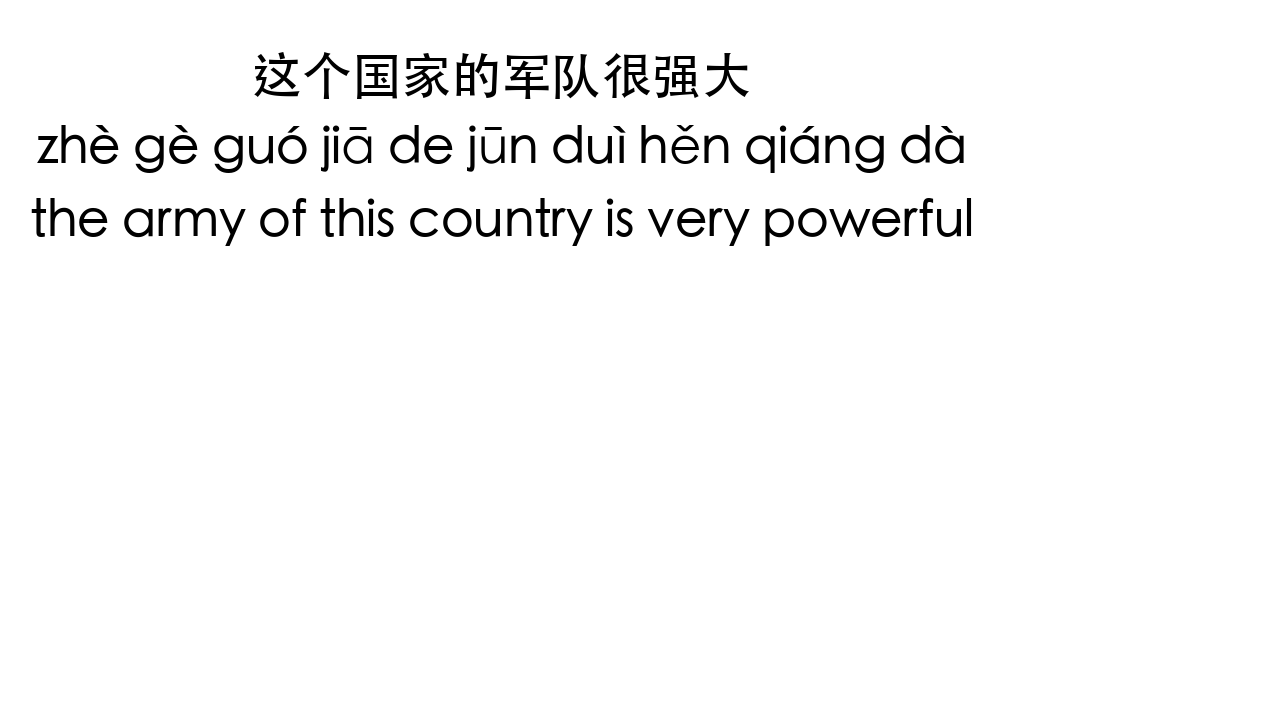

In [77]:
def create_component_words_text(row):
    component_words_text = f"{row['word1']}: {row['word1_english']}\n{row['word2']}: {row['word2_english']}"
    if len(row['word3']) > 0:
        component_words_text += f"\n{row['word3']}: {row['word3_english']}"
    if len(row['word4']) > 0:
        component_words_text += f"\n{row['word4']}: {row['word4_english']}"
    return component_words_text

def get_wrapped_text(text: str, font: ImageFont.ImageFont, line_length: int):
        # TODO: improve this for long strings of chinese characters without spaces
        new_lines = ['']
        for original_line in text.split('\n'):
            words_split = original_line.split(' ')
            for word_idx, word in enumerate(words_split):
                test_line = f'{new_lines[-1]} {word}'.strip()
                if word_idx == 0 and new_lines[-1] != '':
                    new_lines.append(word)
                elif font.getlength(test_line) <= line_length:
                    new_lines[-1] = test_line
                else:
                    new_lines.append(word)
        return '\n'.join(new_lines)


def create_text_clip(
        text, duration, timestamp_start, image_file_name
        , size=(1280, 720)
        , bg_color='white'
        , text_color='black'
        ):
    # Use textcip
    # clip_c = TextClip(text=f"{chinese}\n{pinyin}", font='Marker Felt', font_size=70, color=text_color, bg_color=bg_color, size=size, method='label', duration=duration_text_c)
    font = ImageFont.truetype(hanzi_font_path, 50)
    wrapped_text = get_wrapped_text(text, font, line_length=size[0]-60)

    img = Image.new("RGB", size, color=bg_color)
    draw = ImageDraw.Draw(img)
    draw.multiline_text(
        xy=(30, 50), text=wrapped_text, font=font
        , fill=text_color, spacing=30, align='center'
        )

    img_file_path = f"audio_files/img_for_video/{image_file_name}.png"
    img.save(img_file_path)
    return ImageClip(img_file_path, duration=duration).with_start(timestamp_start)
    
if not os.path.exists(f"audio_files/img_for_video/{rrow['recording_id']}"):
    os.mkdir(f"audio_files/img_for_video/{rrow['recording_id']}")

# Create all clips
clips = []
for idx, row in df_audio_durations[rrow['recording_name']].iterrows():
    if rrow['recording_id'] == '013':
        clips.append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['start_component_words'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        component_words_text = create_component_words_text(row)
        clips.append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{component_words_text}", row['start_english'] - row['start_component_words'], row['start_component_words'], f"{rrow['recording_id']}/{row['chinese']}_component_words"))
        clips.append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{component_words_text}\n{row['english']}", row['start_sent'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_component_words_english"))
        clips.append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}", row['start_sent_english'] - row['start_sent'], row['start_sent'], f"{rrow['recording_id']}/{row['chinese']}_sentence"))
        clips.append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start_sent_english'], row['start_sent_english'], f"{rrow['recording_id']}/{row['chinese']}_sentence_e"))
    elif rrow['recording_id'] == '001':
        clips.append(create_text_clip(f"{row['chinese']} ({row['pinyin']})", row['start_english'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        clips.append(create_text_clip(f"{row['chinese']} ({row['pinyin']}): {row['english']}", row['start_sent'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
        clips.append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}", row['start_sent_english'] - row['start_sent'], row['start_sent'], f"{rrow['recording_id']}/{row['chinese']}_sentence"))
        clips.append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start_sent_english'], row['start_sent_english'], f"{rrow['recording_id']}/{row['chinese']}_sentence_e"))
    elif rrow['recording_id'] in ['014']:
        clips.append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['start_english'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        clips.append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{row['english']}", row['end'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
    elif rrow['recording_id'] in ['015']:
        clips.append(create_text_clip(f"{row['chinese']} ({row['pinyin']}): {row['english']}\n --------- \n{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start'], row['start'], f"{rrow['recording_id']}/{row['chinese']}"))
    else:
        raise ValueError(f"Unknown vlaue of recording_id: {rrow['recording_id']}")
    print(f'{idx}: {row["chinese"]}')

clips[3].display_in_notebook()


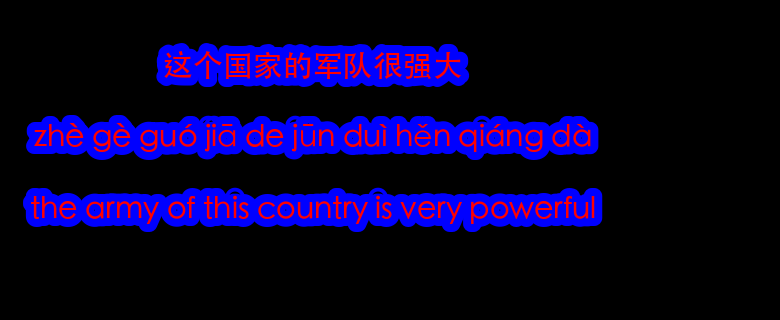

In [76]:
img = Image.new("RGB", (780, 320))
draw = ImageDraw.Draw(img)
draw.multiline_text(xy=(30, 50), text=f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"
                    , font=ImageFont.truetype(hanzi_font_path, 30)
                    , spacing=30
                    , align='center'
                    , fill='red'
                    , direction='ltr'
                    , stroke_width=8
                    , stroke_fill='blue'
                    )
img.save("tmp.png")
ImageClip("tmp.png", duration=1).with_start(0).display_in_notebook()

## 6b. Create video with audio

In [78]:
# Load audio
audio = AudioFileClip(f"audio_files/products/{rrow['recording_name']}.mp3")
audio.duration

# Compare durations of audio and video
all_clips_duration = sum(clip.duration for clip in clips)
print(f"Audio: {audio.duration:.3f} seconds")
print(f"Video: {all_clips_duration:.3f} seconds")

Audio: 4311.190 seconds
Video: 4309.775 seconds


In [79]:
# Combine clips
video = CompositeVideoClip(clips, size=(1280,720))
video.audio = audio
video.duration = audio.duration

# Export video
video.write_videofile(f"audio_files/products/{rrow['recording_name']}_video.mp4", fps=24)

MoviePy - Building video audio_files/products/0827_001_full_word_sent_p3_3_k2_video.mp4.
MoviePy - Writing audio in 0827_001_full_word_sent_p3_3_k2_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video audio_files/products/0827_001_full_word_sent_p3_3_k2_video.mp4



MoviePy - Done !
MoviePy - video ready audio_files/products/0827_001_full_word_sent_p3_3_k2_video.mp4
